# 1: Abstract

In [365]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

# 2: Data preparation

## Transform 'rssi.csv' to track segment passes

In [366]:
df_rssi = pd.read_csv('data/rssi.csv')

In [367]:
# Parse datetime and resort

df_rssi['DateTime'] = pd.to_datetime(df_rssi['DateTime'], format='%Y-%m-%d %H:%M:%S')
df_rssi = df_rssi.sort_values(by='DateTime')
df_rssi = df_rssi.reset_index()
df_rssi['ID'] = df_rssi.index

In [368]:
# Drop invalid RSSI values

df_rssi.loc[(df_rssi['A2_RSSI']<0.9), 'A2_RSSI'] = np.nan
df_rssi.loc[(df_rssi['A2_RSSI']>2.9), 'A2_RSSI'] = np.nan

In [369]:
# create TourID

df_rssi['AreaNumerDif'] = df_rssi['AreaNumber'] - df_rssi['AreaNumber'].shift(-1) # find new stations
df_rssi.loc[df_rssi['AreaNumerDif']>0, 'AreaNumerDif'] = 1 # steps between stations always 1 or -1, depending on train direction
df_rssi.loc[df_rssi['AreaNumerDif']<0, 'AreaNumerDif'] = -1
df_rssi['AreaNumerDif'] = df_rssi['AreaNumerDif'].replace(0, np.nan) # nan where no change of station
df_rssi['AreaNumerDif'] = df_rssi['AreaNumerDif'].fillna(method='backfill') # fill with direction of next station change
df_rssi['AreaNumerDif'] = df_rssi['AreaNumerDif'].fillna(method='ffill') # fill last rows of dataset

df_rssi['AreaNumerDifDif'] = df_rssi['AreaNumerDif'] - df_rssi['AreaNumerDif'].shift(-1) # find shifts of direction
df_rssi.loc[df_rssi['AreaNumerDifDif']!=0, 'AreaNumerDifDif'] = df_rssi.loc[df_rssi['AreaNumerDifDif']!=0, 'ID'] # set row id where direction changes
df_rssi['AreaNumerDifDif'] = df_rssi['AreaNumerDifDif'].replace(0, np.nan) # nan, where no change of direction
df_rssi['AreaNumerDifDif'] = df_rssi['AreaNumerDifDif'].fillna(method='backfill') # fill with TourID of next TourID
df_rssi.rename(columns = {'AreaNumerDifDif':'TourID'}, inplace = True)

# rename tours as 1..n
tours = pd.DataFrame()
tours['TourID']= pd.Series(df_rssi['TourID'].unique())
tours['NewTourID'] = tours.index.values
tours = tours.set_index('TourID')['NewTourID']
df_rssi['TourID'] = df_rssi['TourID'].map(tours)

In [370]:
# create TrackSegment
# (100m track segment length is guessed to be a good compromise between resolution of given data and result precision)

df_rssi['TrackSegment'] = df_rssi['PositionNoLeap'] / 1000
df_rssi['TrackSegment'] = df_rssi['TrackSegment'].astype(int) # cut last digits

In [371]:
# Create SNR

df_rssi['A1_TotalTelDif'] = df_rssi['A1_TotalTel'] - df_rssi['A1_TotalTel'].shift(1)
df_rssi['A1_ValidTelDif'] = df_rssi['A1_ValidTel'] - df_rssi['A1_ValidTel'].shift(1)
df_rssi['SNR1'] = df_rssi['A1_ValidTelDif'] / df_rssi['A1_TotalTelDif']

df_rssi['A2_TotalTelDif'] = df_rssi['A2_TotalTel'] - df_rssi['A2_TotalTel'].shift(1)
df_rssi['A2_ValidTelDif'] = df_rssi['A2_ValidTel'] - df_rssi['A2_ValidTel'].shift(1)
df_rssi['SNR2'] = df_rssi['A2_ValidTelDif'] / df_rssi['A2_TotalTelDif']

In [372]:
# Create transformed dataframe

aggregations = {
    'DateTime': ['first', 'last', 'count'],  # Todo: Close time-gaps between track segments
    'Latitude': 'mean',
    'Longitude': 'mean',
    'A2_RSSI': ['min', 'mean', 'std'],
    'SNR1': ['min', 'mean', 'std'],
    'SNR2': ['min', 'mean', 'std'],
    'Track': 'first'}  # Todo: Track might change within a segment
df_segments = df_rssi.groupby(['TrackSegment', 'TourID']).agg(aggregations)

df_segments.columns = ['_'.join(column) for column in df_segments.columns.to_flat_index()] # flatten multi level columns
df_segments = df_segments.reset_index()  # flatten index


## Adding estops from 'disruptions.csv' as labels

In [373]:
df_disruptions = pd.read_csv('data/disruptions.csv')

In [374]:
# Remove all disruptions except estops
df_disruptions = df_disruptions[df_disruptions['DisruptionCode'] == 960862267]

In [375]:
# Parse datetimes

df_disruptions['DateTime'] = pd.to_datetime(df_disruptions['DateTime'], format='%Y-%m-%d %H:%M:%S')
df_disruptions = df_disruptions.sort_values(by='DateTime')
df_disruptions = df_disruptions.reset_index()

In [376]:
# Read 'velocities.csv' and parse datetimes

df_velocities = pd.read_csv('data/velocities.csv')
df_velocities['DateTime'] = pd.to_datetime(df_velocities['DateTime'], format='%Y-%m-%d %H:%M:%S')
df_velocities = df_velocities.set_index('DateTime')

In [377]:
# Map velocities to disruptions

velocities = []
for _, row in df_disruptions.iterrows():
    if row['DateTime'] in df_velocities.index:
        velocities.append(df_velocities.loc[row['DateTime'], 'CurrentVelocity'])
    else:
        velocities.append(0)
df_disruptions['velocity'] = velocities

In [378]:
# Remove disruptions with velocity equal to zero
df_disruptions = df_disruptions[df_disruptions['velocity'] > 0]

In [379]:
# Count estops per segment pass

def count_estops(dates_series:pd.Series) -> None:
    estops = df_disruptions['DateTime'].between(dates_series[0], dates_series[1])
    return estops.sum()

tqdm.pandas()
estops = df_segments[['DateTime_first', 'DateTime_last']].progress_apply(count_estops, axis=1)
df_segments['n_estops'] = estops

100%|██████████| 1091846/1091846 [06:10<00:00, 2944.06it/s]


In [380]:
df_segments.head()

,TrackSegment,TourID,DateTime_first,DateTime_last,DateTime_count,Latitude_mean,Longitude_mean,A2_RSSI_min,A2_RSSI_mean,A2_RSSI_std,SNR1_min,SNR1_mean,SNR1_std,SNR2_min,SNR2_mean,SNR2_std,Track_first,n_estops
0,97,0,2020-01-22 00:00:01,2020-01-28 08:13:57,59175,47.304858,8.049463,0.93,1.338668,0.225625,0.999611,1.00000,0.000002,0.0,0.960728,0.157886,5,0
1,97,4,2020-01-29 05:40:37,2020-01-29 05:41:15,39,47.305277,8.049646,1.88,2.471282,0.099318,1.000000,1.00000,0.000000,1.0,1.000000,0.000000,5,0
2,97,16,2020-01-30 06:49:43,2020-01-30 16:43:01,18316,47.305015,8.049532,0.93,1.685492,0.114742,0.000000,0.99939,0.015534,0.0,0.999072,0.018709,3,0
3,97,48,2020-02-04 04:41:01,2020-02-04 04:41:19,19,47.305286,8.049649,2.26,2.354211,0.125225,1.000000,1.00000,0.000000,1.0,1.000000,0.000000,2,0
4,97,50,2020-02-04 07:36:48,2020-02-04 16:29:24,31709,47.304984,8.049518,0.93,0.956754,0.074091,0.000000,0.96506,0.158184,1.0,1.000000,0.000000,2,0


In [ ]:
# Write to file
# df_segments.to_csv('data/rssi_segmented.csv')

# 3: Explorational data analysis

## Track number

In [381]:
# For each track segment, 'df_track' contains the number of passes for each track number used

df_tracks = df_segments\
    .loc[:, ['TrackSegment', 'Track_first', 'Latitude_mean']]\
    .groupby(['TrackSegment', 'Track_first'])\
    .count()\
    .unstack(level='Track_first')\
    .droplevel(0, axis='columns')

<AxesSubplot:xlabel='TrackSegment'>

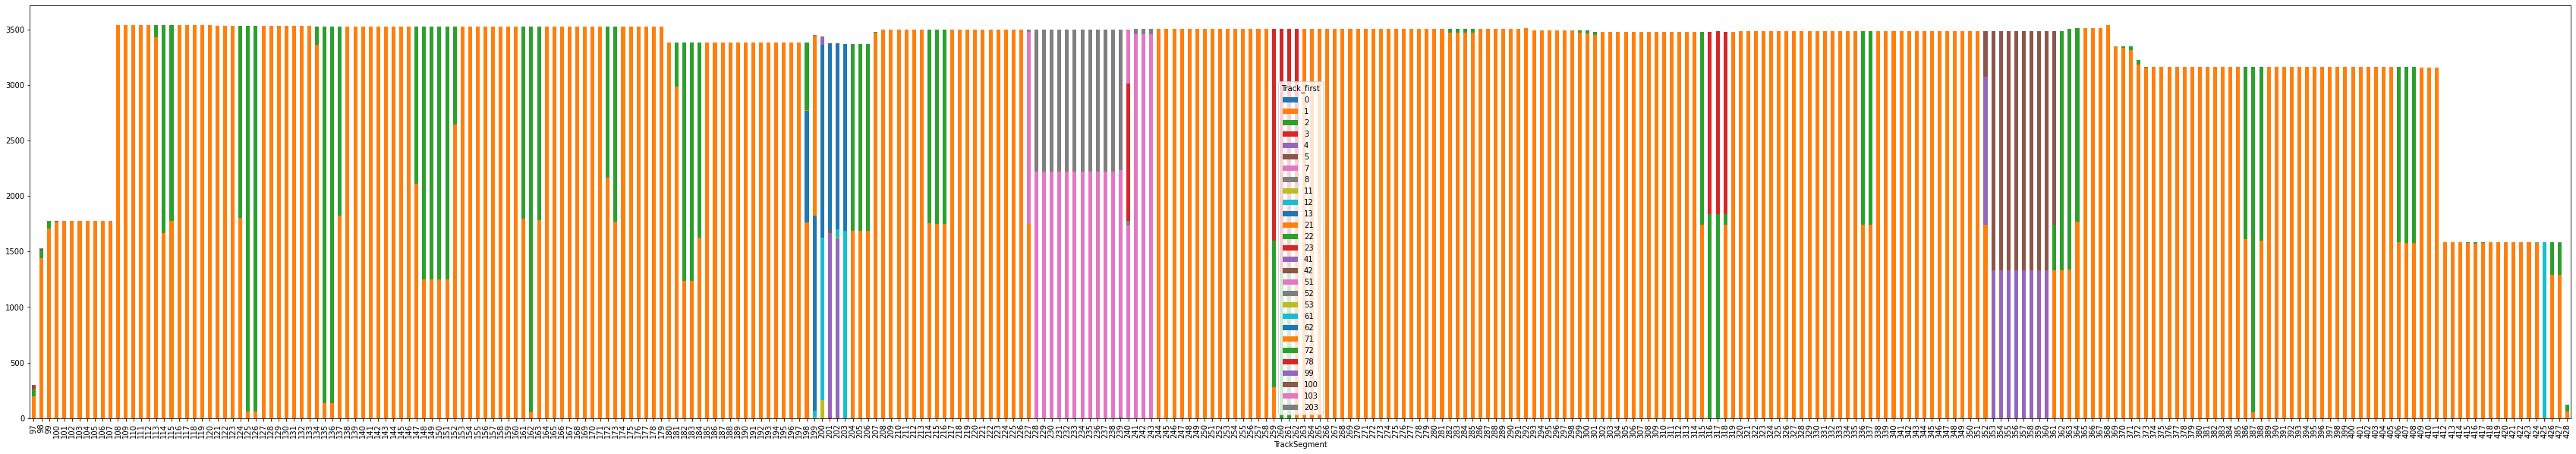

In [382]:
# Plot the number of times, each track number has been used for each track segment

plt.rcParams['figure.figsize'] = [60, 10]
df_tracks.plot.bar(stacked=True)

--> On a significant portion of the track segments, multiple tracks are used in parallel. As we are looking mostly at physical degradation, the forecasting should be done for each track separately. But for now, this will be neglected and all tracks within a track segment will be treated as the same.

## E-stops

In [383]:
estops = df_segments[['n_estops', 'TrackSegment']].groupby('TrackSegment').agg(['sum', 'count'])
estops.columns = ['_'.join(column) for column in estops.columns.to_flat_index()] # flatten multi level columns
estops['estops_per_pass'] = estops['n_estops_sum'] / estops['n_estops_sum']

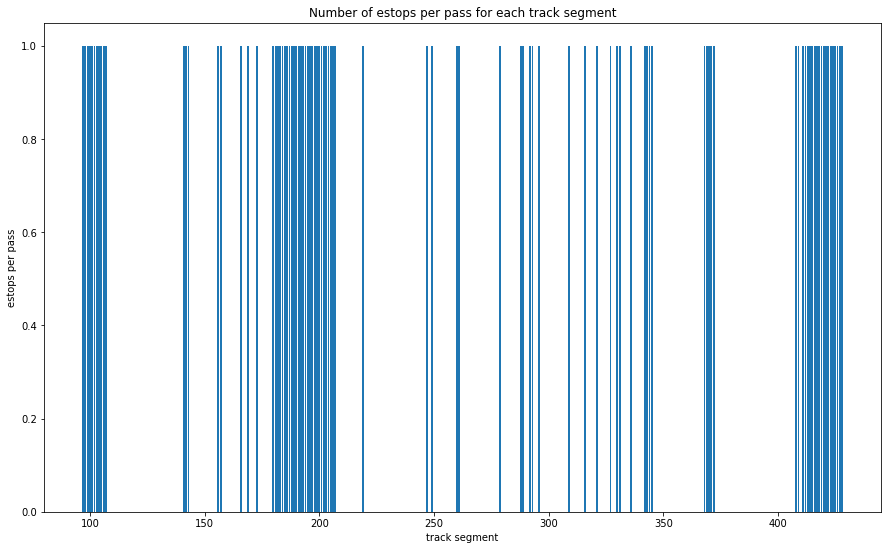

In [384]:
# Plot count of all historical estops grouped by track segment

plt.rcParams['figure.figsize'] = [15, 9]
plt.bar(estops.index, estops['estops_per_pass'])
plt.xlabel('track segment')
plt.ylabel('estops per pass')
plt.title(f"Number of estops per pass for each track segment")
plt.show() # to suppress last object string

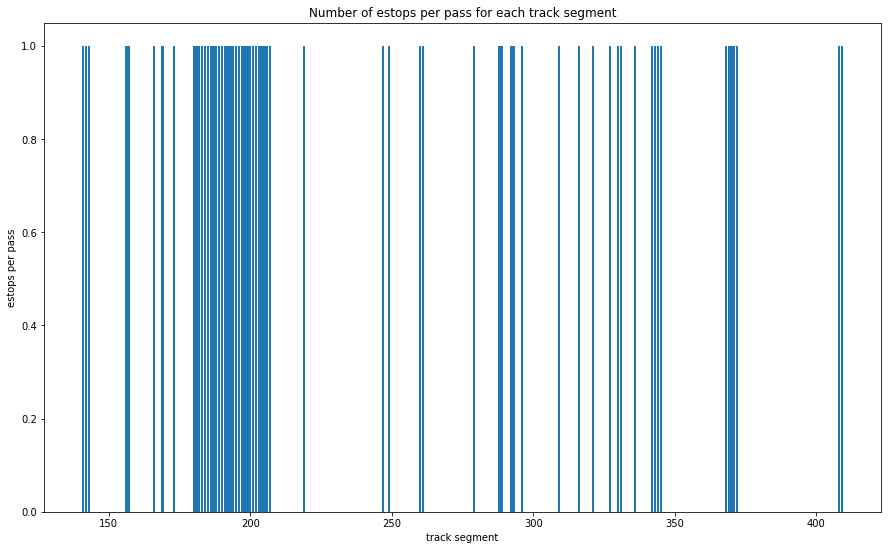

In [385]:
plt.rcParams['figure.figsize'] = [15, 9]
filtered_estops = estops.loc[108:410]
plt.bar(filtered_estops.index, filtered_estops['estops_per_pass'])
plt.xlabel('track segment')
plt.ylabel('estops per pass')
plt.title(f"Number of estops per pass for each track segment")
plt.show() # to suppress last object string

--> High counts of estops seem to correlate with lower numbers of segment usage.

## Features and label for a single track segment

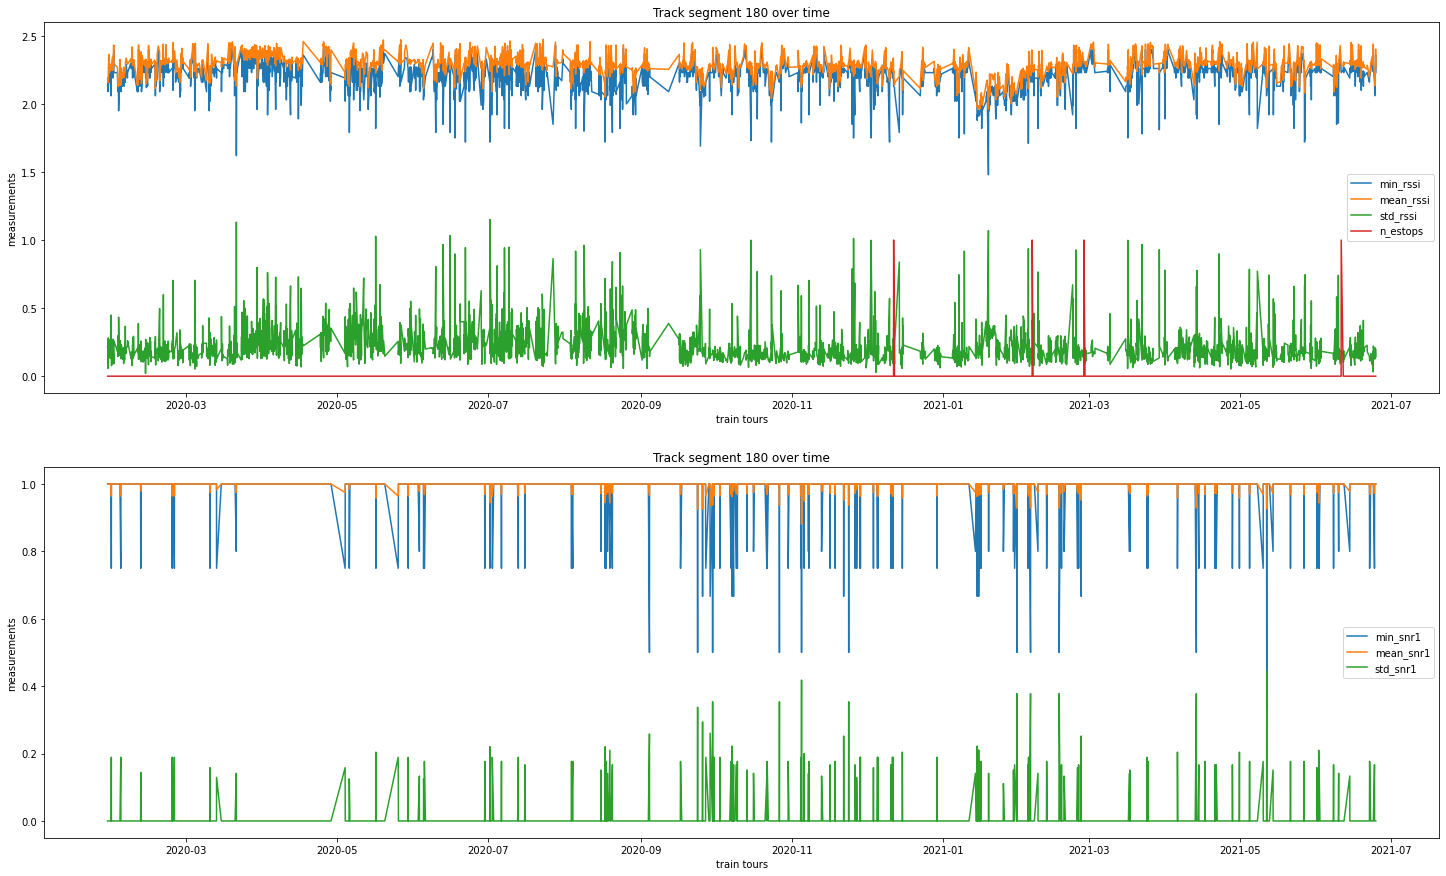

In [386]:
plt.rcParams['figure.figsize'] = [25, 15]
segment_no = 180
segment_mask = df_segments['TrackSegment']==segment_no

x = df_segments.loc[segment_mask, 'DateTime_first']

plt.subplot(211)
min_rssi = df_segments.loc[segment_mask, 'A2_RSSI_min']
plt.plot(x, min_rssi, label='min_rssi')
mean_rssi = df_segments.loc[segment_mask, 'A2_RSSI_mean']
plt.plot(x, mean_rssi, label='mean_rssi')
std_rssi = df_segments.loc[segment_mask, 'A2_RSSI_std']
plt.plot(x, std_rssi * 5, label='std_rssi')
n_estops = df_segments.loc[segment_mask, 'n_estops']
plt.plot(x, n_estops, label='n_estops')
plt.legend(loc='center right')
plt.xlabel('train tours')
plt.ylabel('measurements')
plt.title(f"Track segment {segment_no} over time")

plt.subplot(212)
min_snr1 = df_segments.loc[segment_mask, 'SNR1_min']
plt.plot(x, min_snr1, label='min_snr1')
mean_snr1 = df_segments.loc[segment_mask, 'SNR1_mean']
plt.plot(x, mean_snr1, label='mean_snr1')
std_snr1 = df_segments.loc[segment_mask, 'SNR1_std']
plt.plot(x, std_snr1 * 2, label='std_snr1')
# n_estops = df_segments.loc[segment_mask, 'n_estops']
# plt.plot(x, n_estops, label='n_estops')
plt.legend(loc='center right')
plt.xlabel('train tours')
plt.ylabel('measurements')
plt.title(f"Track segment {segment_no} over time")

plt.show() # to suppress last object string

# 4: Estop clustering

In [413]:
columns = ['TrackSegment', 'TourID', 'n_estops', 'A2_RSSI_min', 'A2_RSSI_mean', 'A2_RSSI_std', 'SNR1_min', 'SNR1_mean', 'SNR1_std']
lag_cols = ['A2_RSSI_min', 'A2_RSSI_mean', 'A2_RSSI_std', 'SNR1_min', 'SNR1_mean', 'SNR1_std']
df_estops = df_segments.loc[df_segments['n_estops']>0, columns]

for lag in range(1, 4):
    lagged_values = df_segments.loc[df_segments['n_estops'].shift(-1)>0, lag_cols]
    for col in lag_cols:
        df_estops[f'{col}-{lag}'] = lagged_values[col].values
        df_estops[f'{col}-{lag}'] = df_estops[f'{col}-{lag}'] / df_estops[col]  # change to relative
        df_estops[f'{col}-{lag}'] = df_estops[f'{col}-{lag}'].replace(np.nan, 1)  # replace nan if base value was 0
        df_estops[f'{col}-{lag}'] = df_estops[f'{col}-{lag}'].replace(np.inf, 1)  # replace inf if base value was 0
df_estops = df_estops.dropna()
df_estops
# But noise is a problem.

,TrackSegment,TourID,n_estops,A2_RSSI_min,A2_RSSI_mean,A2_RSSI_std,SNR1_min,SNR1_mean,SNR1_std,A2_RSSI_min-1,...,A2_RSSI_std-2,SNR1_min-2,SNR1_mean-2,SNR1_std-2,A2_RSSI_min-3,A2_RSSI_mean-3,A2_RSSI_std-3,SNR1_min-3,SNR1_mean-3,SNR1_std-3
20,97,218,1,2.50,2.642575,0.026361,1.000000,1.000000,0.000000,0.372000,...,3.872802,0.000000,0.962038,1.000000,0.372000,0.367165,3.872802,0.000000,0.962038,1.000000
21,97,238,1,2.53,2.617200,0.026561,0.333333,0.999992,0.002150,0.988142,...,0.992483,3.000000,1.000008,0.000000,0.988142,1.009695,0.992483,3.000000,1.000008,0.000000
26,97,296,1,2.46,2.596077,0.021957,1.000000,1.000000,0.000000,1.028455,...,1.134596,1.000000,1.000000,1.000000,1.028455,1.027048,1.134596,1.000000,1.000000,1.000000
34,97,384,1,1.41,2.056712,0.074758,1.000000,1.000000,0.000000,0.858156,...,4.319985,0.000000,0.951605,1.000000,0.858156,0.870813,4.319985,0.000000,0.951605,1.000000
35,97,386,2,0.93,0.972963,0.107753,0.000000,0.820421,0.331018,1.516129,...,0.693786,1.000000,1.218887,0.000000,1.516129,2.113864,0.693786,1.000000,1.218887,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091824,428,3213,1,1.95,2.204630,0.041766,1.000000,1.000000,0.000000,1.020513,...,0.952757,1.000000,1.000000,1.000000,1.020513,0.986185,0.952757,1.000000,1.000000,1.000000
1091827,428,3239,1,1.89,2.211027,0.048068,1.000000,1.000000,0.000000,1.068783,...,1.031044,1.000000,1.000000,1.000000,1.068783,0.981891,1.031044,1.000000,1.000000,1.000000
1091833,428,3405,2,1.99,2.202753,0.047458,0.999644,1.000000,0.000002,1.020101,...,0.931838,1.000356,1.000000,0.000000,1.020101,0.978112,0.931838,1.000356,1.000000,0.000000
1091839,428,3589,6,2.12,2.172073,0.030386,0.999301,1.000000,0.000009,1.084906,...,0.980485,1.000700,1.000000,0.000000,1.084906,1.129669,0.980485,1.000700,1.000000,0.000000


In [411]:

X = df_estops.iloc[:, 3:].to_numpy()

estimator = KMeans(n_clusters=10)
estimator.fit(X)
labels = estimator.labels_

values, counts = np.unique(labels, return_counts=True)
print(values)
print(counts)


[0 1 2 3 4 5 6 7 8 9]
[3038    1    1    1    2    2    1    1    1    4]


# 5: Forecasting of degradation-based estops

# Todo

Data preparation
- Flatten indices and columns after grouping
- Replace values of TrackSegment and TourID by ascending integers
- Create feature of dropped RSSI values
- There are gaps between the segment pass times. Make sure, all estops get mapped to a segment pass. How many are missing?
- Cleanup and structure this doc

Clustering
- Run a clustering of stops, to divide into different types of causes.
  - Estops caused by external reasons and withoud measureable degradations (cow-herd fence, floodings, ...) should be labeled and removed from the labels. There will be no prior worsening of features to use for prediction, so these only add noise to the prediction.
  - For the other estops, a root-cause-analysis can be done after they occured. So best would be two aproaches in parallel.

Forecasting
- Do a forecast
  - Look at all signals prior to an estop. Is there any estop with prior worsening signals?
  - Predict probability of estop in next x days
  - Model the connection of estops to features, then forecast features and determine future estops by trained model
  
Frontend
- Show all results in maps